In [6]:
import os
import time
import glob
import gdown
import torch
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

In [7]:
def download_weights():
    model_file=[
        'yolo_face_sthanhng.weights',
        'yolo_face_sthanhng.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1utquM5TAnfIa1Aq0X9fCvrllHiTWazdD',
        'https://drive.google.com/uc?id=1CPUZlYL5ik4d9y6oCyzi0930KgzawI6V'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [8]:
# download the necessary weights for YOLO-Face
download_weights()

yolo_face_sthanhng.weights:: status : file already exists
yolo_face_sthanhng.cfg:: status : file already exists


## YOLOFace with FGSM

In [9]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [10]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))


In [49]:
#TODO: update the paths as needed

FOLDER_PATH = os.path.join(os.getcwd(), 'images')
BBOX_PATH = os.path.join(os.getcwd(), 'images_box')
PAD_PATH = os.path.join(os.getcwd(), 'images_pad')

if not os.path.exists(BBOX_PATH):
    os.mkdir(BBOX_PATH)

if not os.path.exists(PAD_PATH):
    os.mkdir(PAD_PATH)
    
def pipeline(model, device):
    
    df = pd.DataFrame() # dataframe storing the dataset
    row = {} #the information/columns for a single row in the dataset is stored here
    
    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, '*.jpg')):
        
        row['path'] = path
        row['source_file'] = path.split("\\")[-1]
        print(path)
        print(row['source_file'])
        
        # read and transform the image from the path
        data = cv2.imread(path)  # read the image
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
        
        # Forward pass the data through the model
        output = model(data)
        
        # call non max suppression
        nms, nms_output = non_max_suppression(output, 0.5, 0.5) #conf_thres and iou_thres = 0.5
        
        # loop through each of the faces in the image
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            row['face_index'] = face_index
            print('Face ', face_index)
            
            # get the coordinate of the face bounding box
            #(x1, y1) upper left, (x2, y2) lower right
            x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]
            
            # cropped image with bounding box
            # getting (x1, y1) upper left, (x2, y2) lower right
            x1 = int(np.floor((x - w / 2).detach().cpu().numpy()))
            y1 = int(np.floor((y - h / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((x + w / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((y + h / 2).detach().cpu().numpy()))
            
            row['x1'], row['y1'], row['x2'], row['y2'] = x1, y1, x2, y2
            
            print('Cropped')
            print(x1, y1, x2, y2)
            
            bbox_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            bbox_image = tensor_to_image(bbox_image) #reshape the image to (w/h, h/w, channel)
            bbox_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((bbox_image, np.zeros((1, 5))))[0], (1, 2, 0)).numpy() # resize image to 128x128
            bbox_image = (bbox_image * 255).astype(np.uint8)
            plt.imshow(bbox_image)
            plt.show()
            
            bbox_image = cv2.cvtColor(bbox_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(BBOX_PATH, row['source_file'] + str(face_index) + '.jpg'), bbox_image)
            
            # getting (x1, y1) upper left, (x2, y2) lower right
             # cropped image with bounding box + some padding
            x1_pad = max(int(np.floor((x - w).detach().cpu().numpy())), 0) # prevent negative values
            y1_pad = max(int(np.floor((y - h).detach().cpu().numpy())), 0)
            x2_pad = min(int(np.ceil((x + w).detach().cpu().numpy())), 415) # prevent from getting out of range
            y2_pad = min(int(np.ceil((y + h).detach().cpu().numpy())), 415)
            
            row['x1_pad'], row['y1_pad'], row['x2_pad'], row['y2_pad'] = x1_pad, y1_pad, x2_pad, y2_pad
            
            pad_image = detach_cpu(data)[:, :, y1_pad:y2_pad, x1_pad:x2_pad] #get the first dimension, the channels, and crop it
            pad_image = tensor_to_image(pad_image) #reshape the image to (w/h, h/w, channel)
            pad_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((pad_image, np.zeros((1, 5))))[0], (1, 2, 0)).numpy() # resize image to 128x128
            pad_image = (pad_image * 255).astype(np.uint8)
            plt.imshow(pad_image)
            plt.show()
            
            pad_image = cv2.cvtColor(pad_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(PAD_PATH, row['source_file'] + str(face_index) + '.jpg'), pad_image)
            
            #add tow to dataset
            df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe
            
    df.to_csv(os.path.join(FOLDER_PATH, 'dataset' + str(int(time.time())) + '.csv'), index=False)  #save to csv

E:\Documents\GitHub\THS-ST1\images\couple.jpg
couple.jpg
Face  0
Cropped
91 158 188 276


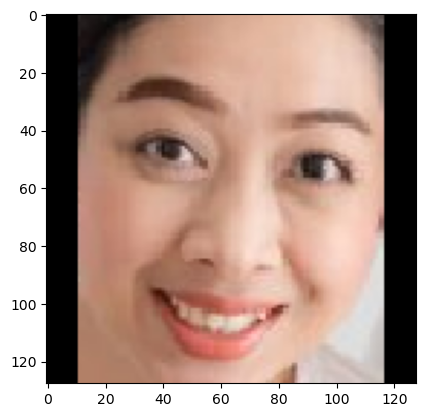

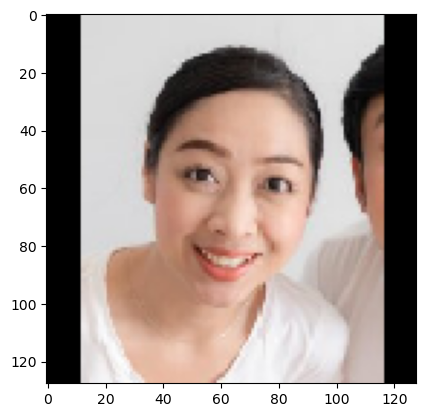

C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_912\3742657172.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


Face  1
Cropped
224 137 322 277


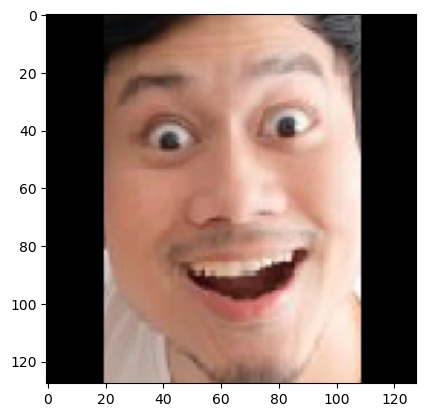

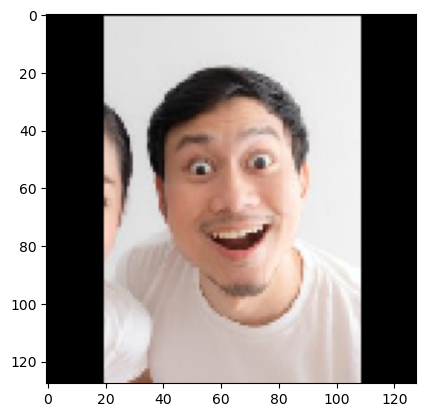

C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_912\3742657172.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


E:\Documents\GitHub\THS-ST1\images\girl.jpg
girl.jpg
Face  0
Cropped
126 129 289 350


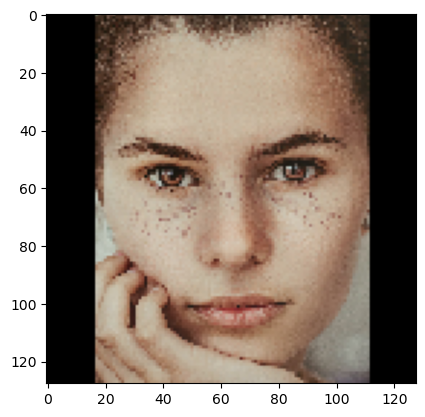

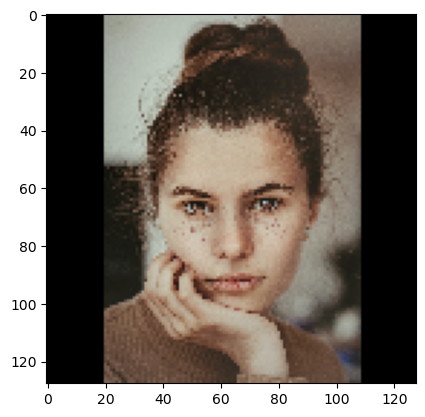

C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_912\3742657172.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


In [50]:
pipeline(model, device)